# Machine Learning with PyTorch

## Comparing Machine Learning Libraries

For this overview example, we will create a classification model using:

1. scikit-learn
2. Keras
3. PyTorch

In [1]:
import warnings
warnings.filterwarnings("ignore")

## scikit-learn style

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
X_scaled = StandardScaler().fit_transform(cancer.data)
print("Original data (rows, features):", X_scaled.shape)

Original data (rows, features): (569, 30)


In [4]:
%%time
# Generating to polynomial features is not that time consuming
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_scaled)
print("All polynomial features (order 2):", X_poly.shape)

All polynomial features (order 2): (569, 496)
CPU times: user 3.76 ms, sys: 0 ns, total: 3.76 ms
Wall time: 3.45 ms


In [5]:
%%time
# A fairly generic random forest
rfc = RandomForestClassifier(max_depth=7, n_estimators=10, random_state=1)

# Do some work to pick the optimal number of features
# "Recursive feature elimination using cross-validation"
rfecv = RFECV(estimator=rfc, cv=5, n_jobs=-1)
X_poly_top = rfecv.fit_transform(X_poly, cancer.target)

# The "top" features selected for the model
print("Best polynomial features", X_poly_top.shape)

Best polynomial features (569, 475)
CPU times: user 1.18 s, sys: 219 ms, total: 1.4 s
Wall time: 18.5 s


In [6]:
%%time
# Do a train/test split on the "poly_top" features
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_top, cancer.target, random_state=42)

# Train the selected RFC model
rfc = RandomForestClassifier(max_depth=7, n_estimators=10, random_state=1)
print("Test accuracy:", rfc.fit(X_train, y_train).score(X_test, y_test))

Test accuracy: 0.951048951048951
CPU times: user 36.7 ms, sys: 4.74 ms, total: 41.5 ms
Wall time: 40.3 ms


## Neural Networks

There are several things to notice in our NN setup.  We do *not* generate polynomial features.  Instead, we allow the network itself to derive them on a first layer we arrange to have the same number of neurons as there were polynomial features in our Random Forest approach.

In [7]:
batch_size = 32
in_dim = cancer.data.shape[1]
hidden1 = X_poly_top.shape[1]   # The size of layer that deduces poly features
hidden2 = 20                    # The size of the "inference layer"
out_dim = 1                     # Output a single value

batches_in_data = X_train.shape[0]/batch_size
epochs = int(5000/batches_in_data)
learning_rate = 1e-4

# Split the original data
X_train, X_test, y_train, y_test = train_test_split(
                           cancer.data, cancer.target, random_state=42)
cancer.data.shape   # The shape of the data being split

(569, 30)

## Keras style

In [8]:
# import keras
import tensorflow.keras as keras

In [9]:
keras.__version__

'2.4.0'

In [10]:
model_k = keras.models.Sequential([
    # This layer allows "polynomial features"
    keras.layers.Dense(hidden1, activation='relu', input_shape=(in_dim,)),
    # This layer is the essential "inference"
    keras.layers.Dense(hidden2),
    # Often Leaky ReLU eliminates the "dead neuron" danger
    keras.layers.LeakyReLU(),
    # A Dropout layer sometimes reduces co-adaptation of neurons
    keras.layers.Dropout(rate=0.25),
    # A sigmoid activation is used for a binary decision
    keras.layers.Dense(out_dim, activation='sigmoid')
])

In [11]:
model_k.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 475)               14725     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                9520      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 20)                0         
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 24,266
Trainable params: 24,266
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time
# The default optimization is Root Mean Square Propogation
model_k.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.RMSprop(lr=learning_rate),
                metrics=['accuracy'])

history = model_k.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=False,
                      validation_data=(X_test, y_test))

score = model_k.evaluate(X_test, y_test, verbose=True)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 812us/step - loss: 0.0743 - accuracy: 0.9231
Test loss: 0.0742734894156456
Test accuracy: 0.9230769276618958
CPU times: user 25.3 s, sys: 1.09 s, total: 26.4 s
Wall time: 20.7 s


In [13]:
%%time
# Sometimes we do better using Adaptive Moment Optimization
model_k.compile(loss='mean_squared_error',
                optimizer=keras.optimizers.Adam(lr=learning_rate),
                metrics=['accuracy'])

history = model_k.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=False,
                      validation_data=(X_test, y_test))
score = model_k.evaluate(X_test, y_test, verbose=True)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 707us/step - loss: 0.0305 - accuracy: 0.9580
Test loss: 0.030488967895507812
Test accuracy: 0.9580419659614563
CPU times: user 32.3 s, sys: 5.8 s, total: 38.1 s
Wall time: 20.9 s


## PyTorch style

In [14]:
import numpy as np
import torch
from torch.autograd import Variable

In [15]:
# Create a sequential NN
model_t = torch.nn.Sequential(
    # This layer allows "polynomial features"
    torch.nn.Linear(in_dim, hidden1),
    # The activation is treated as a separate layer
    torch.nn.ReLU(),
    # This layer is the essential "inference"
    torch.nn.Linear(hidden1, hidden2),
    # Often Leaky ReLU eliminates the "dead neuron" danger
    torch.nn.LeakyReLU(), 
    # A Dropout layer sometimes reduces co-adaptation of neurons
    torch.nn.Dropout(p=0.25),
    # A sigmoid activation is used for a binary decision
    torch.nn.Linear(hidden2, out_dim),  
    torch.nn.Sigmoid()
)

In [16]:
from torch import device, cuda
from torchsummary import summary

# torchsummary has a glitch. If running on a CUDA-enabled build
# it only wants to print a CUDA model
if cuda.is_available():
    model_t = model_t.to(device('cuda'))
    
summary(model_t, input_size=(1,in_dim))

# model_t = model_t.to(device('cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 475]          14,725
              ReLU-2               [-1, 1, 475]               0
            Linear-3                [-1, 1, 20]           9,520
         LeakyReLU-4                [-1, 1, 20]               0
           Dropout-5                [-1, 1, 20]               0
            Linear-6                 [-1, 1, 1]              21
           Sigmoid-7                 [-1, 1, 1]               0
Total params: 24,266
Trainable params: 24,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [17]:
show_every = 250

def do_training():
    for t in range(5000):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model_t(X)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        if not t % show_every:
            y_test_pred = model_t(Variable(X_test_T))
            prediction = [int(x > 0.5) 
                          for x in y_test_pred.data.cpu().numpy()]
            test_accuracy = (prediction == y_test).sum() / len(y_test)
            train_pred = [int(x > 0.5) 
                          for x in y_pred.data.cpu().numpy()]
            train_accuracy = (train_pred == y_train).sum() / len(y_train)
            print("Batch: %04d | Training Loss: %6.2f | Train accuracy: %.4f | Test accuracy: %.4f" % (
                          t, loss.item(), train_accuracy, test_accuracy))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

In [18]:
%%time
## Now run model
X = torch.from_numpy(X_train).float()
y = torch.from_numpy(y_train[:, np.newaxis]).float()
X_test_T = torch.from_numpy(X_test).float()
y_test_T = torch.from_numpy(y_test[:, np.newaxis]).float()

if cuda.is_available():
    X = X.to(device('cuda'))
    y = y.to(device('cuda'))
    X_test_T = X_test_T.to(device('cuda'))
    y_test_T = y_test_T.to(device('cuda'))

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.RMSprop(model_t.parameters(), lr=learning_rate)
do_training()

Batch: 0000 | Training Loss: 228.18 | Train accuracy: 0.3756 | Test accuracy: 0.4056
Batch: 0250 | Training Loss:  30.32 | Train accuracy: 0.9061 | Test accuracy: 0.9510
Batch: 0500 | Training Loss:  26.34 | Train accuracy: 0.9272 | Test accuracy: 0.9510
Batch: 0750 | Training Loss:  24.46 | Train accuracy: 0.9202 | Test accuracy: 0.9510
Batch: 1000 | Training Loss:  42.53 | Train accuracy: 0.8779 | Test accuracy: 0.9231
Batch: 1250 | Training Loss:  22.25 | Train accuracy: 0.9366 | Test accuracy: 0.9510
Batch: 1500 | Training Loss:  21.25 | Train accuracy: 0.9390 | Test accuracy: 0.9441
Batch: 1750 | Training Loss:  22.03 | Train accuracy: 0.9319 | Test accuracy: 0.9371
Batch: 2000 | Training Loss:  22.08 | Train accuracy: 0.9390 | Test accuracy: 0.9301
Batch: 2250 | Training Loss:  18.84 | Train accuracy: 0.9390 | Test accuracy: 0.9441
Batch: 2500 | Training Loss:  19.45 | Train accuracy: 0.9413 | Test accuracy: 0.9441
Batch: 2750 | Training Loss:  17.92 | Train accuracy: 0.9437 | Te

In [19]:
optimizer = torch.optim.Adam(model_t.parameters(), lr=learning_rate)
do_training()

Batch: 0000 | Training Loss:  15.04 | Train accuracy: 0.9577 | Test accuracy: 0.9510
Batch: 0250 | Training Loss:  11.43 | Train accuracy: 0.9671 | Test accuracy: 0.9580
Batch: 0500 | Training Loss:  12.30 | Train accuracy: 0.9742 | Test accuracy: 0.9301
Batch: 0750 | Training Loss:   8.64 | Train accuracy: 0.9765 | Test accuracy: 0.9441
Batch: 1000 | Training Loss:   8.88 | Train accuracy: 0.9765 | Test accuracy: 0.9371
Batch: 1250 | Training Loss:   6.53 | Train accuracy: 0.9812 | Test accuracy: 0.9371
Batch: 1500 | Training Loss:   7.54 | Train accuracy: 0.9742 | Test accuracy: 0.9441
Batch: 1750 | Training Loss:   5.77 | Train accuracy: 0.9859 | Test accuracy: 0.9371
Batch: 2000 | Training Loss:   6.00 | Train accuracy: 0.9789 | Test accuracy: 0.9510
Batch: 2250 | Training Loss:   5.26 | Train accuracy: 0.9859 | Test accuracy: 0.9580
Batch: 2500 | Training Loss:   5.20 | Train accuracy: 0.9812 | Test accuracy: 0.9441
Batch: 2750 | Training Loss:   2.57 | Train accuracy: 0.9977 | Te

### Make a few predictions with trained model

Run the below code several times.  Because it uses a Dropout layer, the activated neurons—and hence the exact predictions—will vary on each call.  Ideally the results will be consistent in identifying the binary class, but they will not be precisely identical in floating point value output in range `[0,1]`.

In [20]:
predictions = model_t(X_test_T[:10])
for row, prediction in enumerate(predictions):
    print("Observation %d; probability benign: %0.3f%%" % (row, prediction*100))

Observation 0; probability benign: 93.569%
Observation 1; probability benign: 0.000%
Observation 2; probability benign: 0.000%
Observation 3; probability benign: 100.000%
Observation 4; probability benign: 100.000%
Observation 5; probability benign: 0.000%
Observation 6; probability benign: 0.000%
Observation 7; probability benign: 45.519%
Observation 8; probability benign: 99.915%
Observation 9; probability benign: 99.501%


## Classifying an image

In [21]:
%matplotlib inline
import json
import numpy as np
from PIL import Image
from IPython.display import display
from torchvision.transforms import Resize, ToTensor, Compose
import torchvision.models as models
import torch

inception = models.inception_v3(pretrained=True).eval()

In [22]:
# Load the imagenet labels for 1000 pre-trained image classes
class_defs = json.load(open("data/imagenet_class_index.json"))
labels = {int(k):name for k, (code, name) in class_defs.items()}

# Small utility to load, resize and tensorize images
def load_images(fnames):
    for fname in fnames:
        image = Image.open(fname)
        image_t = Compose([Resize(299), ToTensor()])(image).float()
        image_t = torch.tensor(image_t, requires_grad=True)
        yield image, image_t.unsqueeze(0)

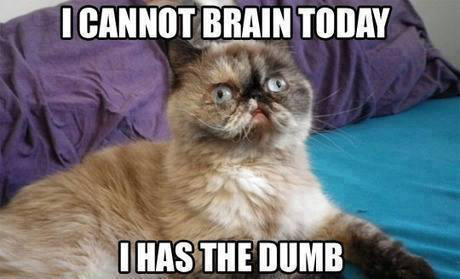

Persian_cat
——————————————————————————————————————————————————————————————————————


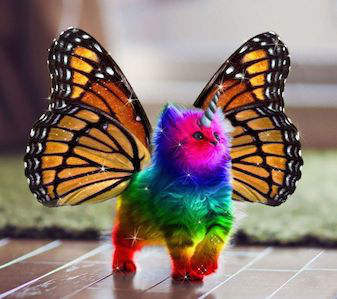

monarch
——————————————————————————————————————————————————————————————————————


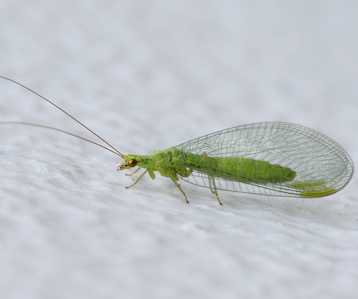

lacewing
——————————————————————————————————————————————————————————————————————


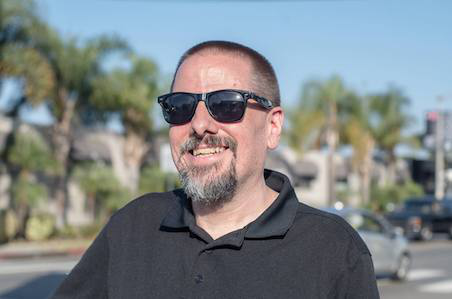

sunglass
——————————————————————————————————————————————————————————————————————


In [23]:
for image, image_tensor in load_images([
            'img/cannot-brain.jpg', 
            'img/rainbox-butterfly-unicorn-kitten.jpg',
            'img/Crisopid_July_2013-9.jpg',
            'img/dqm-bokeh-palms.jpg']):
    outputs = inception(image_tensor)
    prediction = np.argmax(outputs.detach().numpy())
    display(image)
    print(labels[prediction])
    print('—'*70)

## Next Lesson

**Diving Deeper**: We have seen a few brief examples of PyTorch in use, and illustrated a little bit about how its APIs differ from those of other libraries.  Next we will look at some of the essential concept in the design of PyTorch.

<a href="IntroPyTorch.ipynb"><img src="img/open-notebook.png" align="left"/></a>